In [1]:
# AETZ model replication using pytorch

import torch
from torch import nn
import numpy as np
import aet_net
import aet_dyn
from sklearn.manifold import TSNE

# get CUDA index
DEVICE = torch.cuda.current_device()

import matplotlib.pyplot as plt
from itertools import combinations


plt.rcParams["figure.figsize"] = (18,3)

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font',**font)

In [2]:
#initialize model
nn_dim_ = [28,68,3]
eta_ = 0.15
mini_sz_ = 1
num_epo_ = 2000
kl_reg_ = []#[0,0.001]
sig_param = [2, -2.5]

#lossfun = [nn.BCELoss(), nn.Sigmoid()]
#lossfun = [aet_net.CE_loss, nn.Softmax(dim=0)]
lossfun = [nn.MSELoss(), nn.Softmax(dim=0)]
params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param


model = aet_net.net(params,lossfun)
model = aet_net.init_params(model,weight_init='normal')
model = model.to(DEVICE)

Text(0.5, 0, 'epoch')

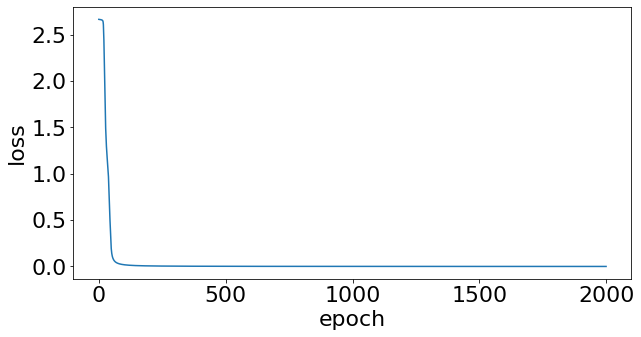

In [3]:
# train model
plt.rcParams["figure.figsize"] = (10,5)

optimizer = torch.optim.SGD(model.parameters(),lr=eta_)

loss_hist = model.train(optimizer,noise=False,print_loss=False)
plt.plot(np.arange(model.num_ep),loss_hist.cpu().detach().numpy())
plt.ylabel('loss')
plt.xlabel('epoch')

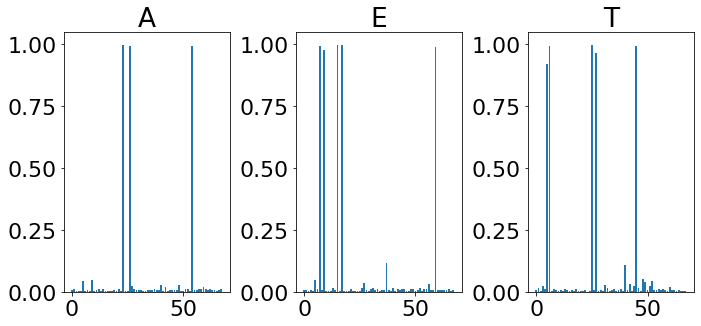

In [4]:
x_train, y_train = aet_net.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

# subset of inputs
idx = np.array((0,5,10))#,-1))
data_sub = x_train[idx]
#label = ['A','E','T','Z']
label = ['A','E','T']

fig, axs = plt.subplots(1,3)
axs = axs.ravel()

for i,ax in enumerate(axs):
    Z,H,O = model.forw_conv(data_sub[i])
    
    ax.bar(np.arange(model.dims[1]),H.cpu().detach().numpy())
    ax.set_title(label[i])
    
fig.tight_layout()

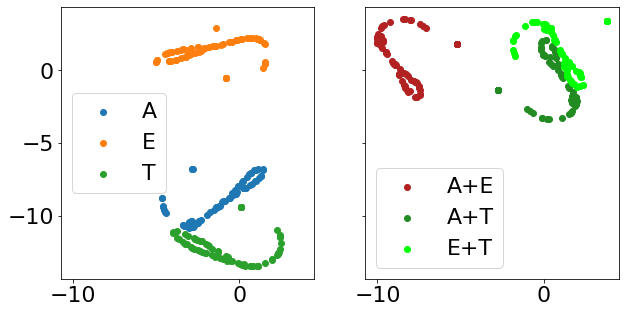

In [5]:
# TSNE visualization
plt.rcParams["figure.figsize"] = (10,5)
perp_ = nn_dim_[1]/2

fig, ax = plt.subplots(1,2,sharex=True,sharey=True)

for i,data in enumerate(data_sub):
    
    H = model.forw_conv(data)[1].detach().cpu().numpy()
    H_embedded = TSNE(n_components=2, learning_rate='auto',init='random',perplexity=perp_).fit_transform(H.reshape(-1,1))
    ax[0].scatter(H_embedded[:,0],H_embedded[:,1])

ax[0].legend(('A','E','T'))

col = ['firebrick', 'forestgreen','lime']

inp_combi = list(combinations(idx,2))           # possible combinations
for i,data in enumerate(data_sub):
    
    input_ = x_train[inp_combi[0][0]] *1.1+ x_train[inp_combi[0][1]]*0.9
    H = model.forw_conv(input_)[1].detach().cpu().numpy()
    H_embedded = TSNE(n_components=2, learning_rate='auto',init='random',perplexity=perp_).fit_transform(H.reshape(-1,1))
    ax[1].scatter(H_embedded[:,0],H_embedded[:,1],color=col[i])
    
ax[1].legend(('A+E','A+T','E+T'))


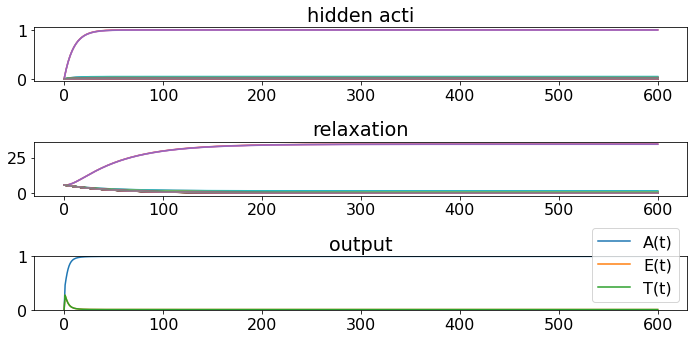

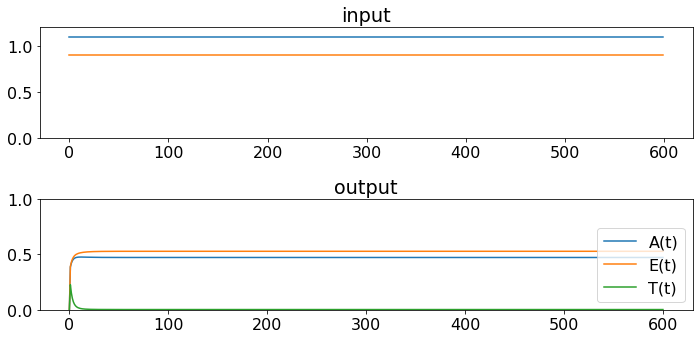

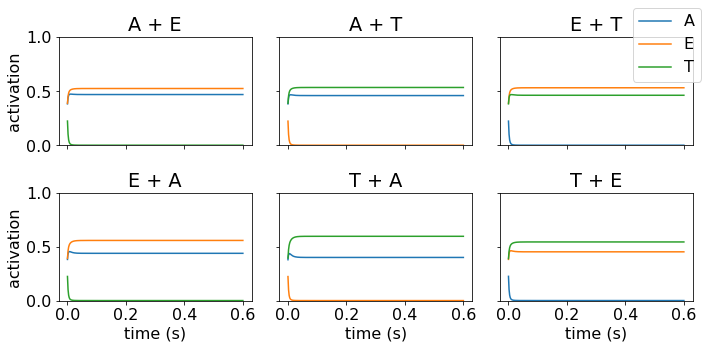

In [6]:
# euler without relaxation
plt.rcParams["figure.figsize"] = (10,5)
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font',**font)


alpha_params = [10,0]
dyn_params = [0.01,0.05,6,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
_io = 0

timevec = np.linspace(0,0.6,600)

Z_t,H_t, R_t, O_t  = aet_dyn.euler_non_dyn(model,x_train[0], dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

fig,ax = plt.subplots(3,1)
ax[2].plot(O_t.T.cpu().detach().numpy())
ax[2].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[2].set_title('output')
ax[2].set_ylim((0,1))

ax[1].plot(R_t.T.cpu().detach().numpy())
ax[1].set_title('relaxation')
ax[0].plot(H_t.T.cpu().detach().numpy())
ax[0].set_title('hidden acti')

if alpha_params[1]:
    alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
    ax[2].plot(alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0].plot(alpha_inh,'k',linewidth=1,linestyle='-.')
fig.tight_layout()

fig.savefig('euler_A.png')



input_ = x_train[inp_combi[0][0]] *1.1+ x_train[inp_combi[0][1]]*0.9
Z_t,H_t, R_t, O_t  = aet_dyn.euler_non_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

in_ = np.concatenate((np.ones((1,len(timevec)))*1.1,np.ones((1,len(timevec)))*.9),axis=0).T
fig,ax = plt.subplots(2,1)
ax[1].plot(O_t.T.cpu().detach().numpy())
ax[1].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[1].set_title('output')
ax[1].set_ylim((0,1))

ax[0].plot(in_)
ax[0].set_ylim((0,1.2))
ax[0].set_title('input')

if alpha_params[1]:
    if alpha_params[1]:
        alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
        ax[2].plot(alpha_inh,'k',linewidth=0.5,linestyle='-.')
        ax[0].plot(alpha_inh,'k',linewidth=1,linestyle='-.')
fig.tight_layout()

fig.savefig('euler_comp.png')

fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
#ax = ax.ravel()
plt.setp(ax,yticks=np.arange(0,1.5,0.5))

ax[0][0].set_ylabel('activation')
ax[1][0].set_ylabel('activation')
for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
    _,_,_,O_t = aet_dyn.euler_non_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)
    
    ax[0][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
    
    if alpha_params[1]:
        ax[0][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
    ax[0][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])

for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
    _,_,_,O_t = aet_dyn.euler_non_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)
    
    ax[1][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
    if alpha_params[1]:
        ax[1][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[1][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
    ax[1][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
    ax[1][i].set_xlabel('time (s)')
    
fig.legend((label))
fig.tight_layout()

fig.savefig('euler_comp_all.png')

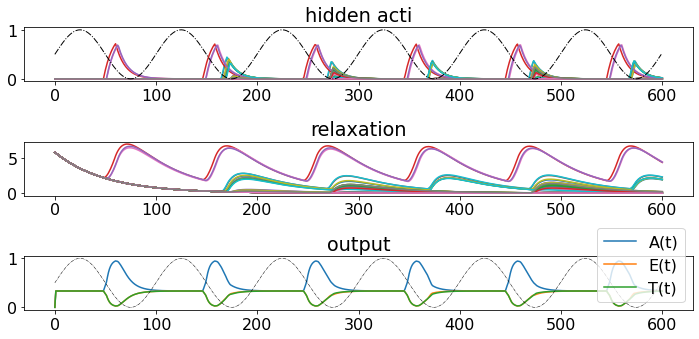

In [7]:
# dynamics
plt.rcParams["figure.figsize"] = (10,5)
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font',**font)


alpha_params = [10,3]
dyn_params = [0.01,0.05,6,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
_io = 0

timevec = np.linspace(0,0.6,600)

Z_t,H_t, R_t, O_t  = aet_dyn.euler_dyn(model,x_train[0], dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

fig,ax = plt.subplots(3,1)
ax[2].plot(O_t.T.cpu().detach().numpy())
ax[2].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[2].set_title('output')

ax[1].plot(R_t.T.cpu().detach().numpy())
ax[1].set_title('relaxation')
ax[0].plot(H_t.T.cpu().detach().numpy())
ax[0].set_title('hidden acti')

if alpha_params[1]:
    alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
    ax[2].plot(alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0].plot(alpha_inh,'k',linewidth=1,linestyle='-.')
fig.tight_layout()

fig.savefig('dyna_alpha_A.png')


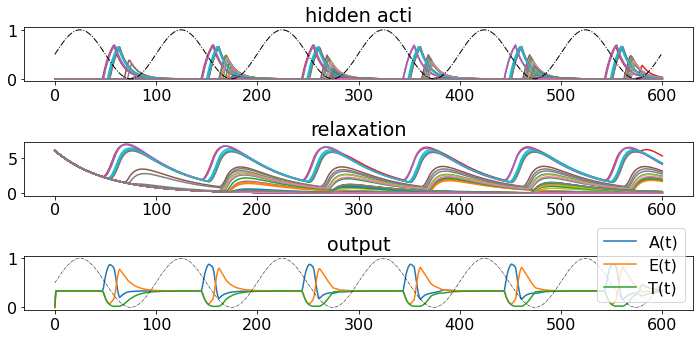

In [8]:
# competing inputs + dynamics
#plt.rcParams["figure.figsize"] = (15,5)

alpha_params = [10,3]
dyn_params = [0.01,0.05,6,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
_io = 0

timevec = np.linspace(0,0.6,600)
inp_combi = list(combinations(idx,2))           # possible combinations

input_ = x_train[inp_combi[0][0]] *1.1+ x_train[inp_combi[0][1]]*0.9
Z_t,H_t, R_t, O_t  = aet_dyn.euler_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)


fig,ax = plt.subplots(3,1)
ax[2].plot(O_t.T.cpu().detach().numpy())
ax[2].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[2].set_title('output')

ax[1].plot(R_t.T.cpu().detach().numpy())
ax[1].set_title('relaxation')
ax[0].plot(H_t.T.cpu().detach().numpy())
ax[0].set_title('hidden acti')

if alpha_params[1]:
    if alpha_params[1]:
        alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
        ax[2].plot(alpha_inh,'k',linewidth=0.5,linestyle='-.')
        ax[0].plot(alpha_inh,'k',linewidth=1,linestyle='-.')
fig.tight_layout()

if alpha_params[1]:
    fig.savefig('dyna_comp_AE_alpha.png')
else:
    fig.savefig('dyna_comp_AE_no_alpha.png')


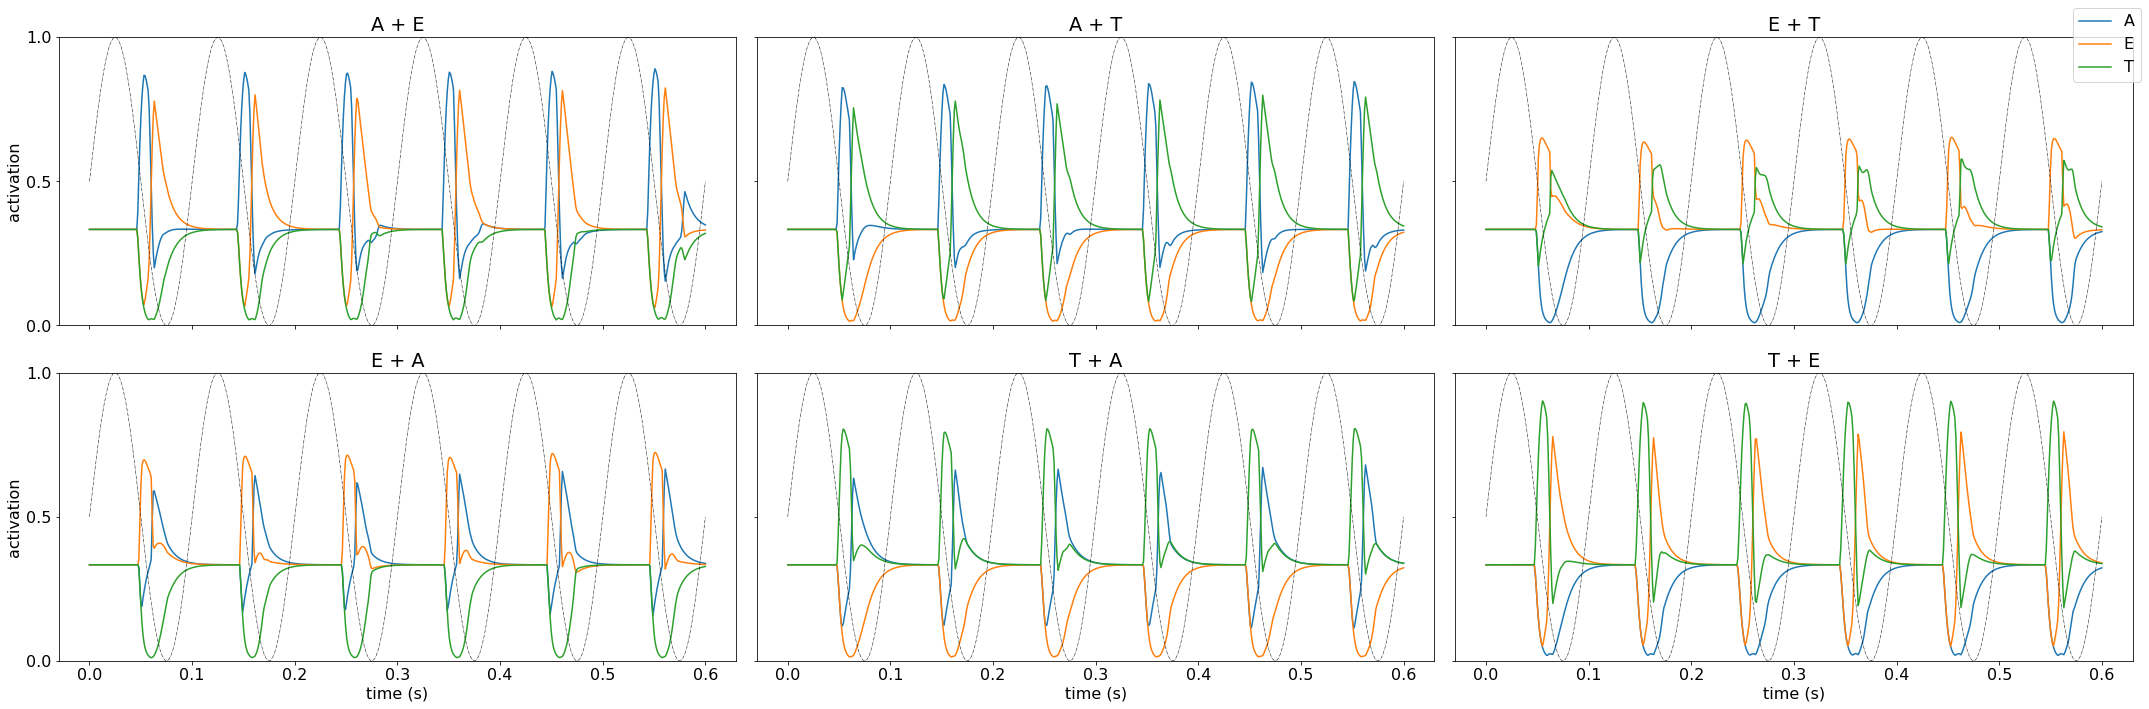

In [9]:
plt.rcParams["figure.figsize"] = (30,10)
# all combinations#
alpha_params = [10,3]
dyn_params = [0.01,0.05,6,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
_io = 0
timevec = np.linspace(0,0.6,600)
fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
#ax = ax.ravel()
plt.setp(ax,yticks=np.arange(0,1.5,0.5))

ax[0][0].set_ylabel('activation')
ax[1][0].set_ylabel('activation')

alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
    _,_,_,O_t = aet_dyn.euler_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)
    
    ax[0][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
    
    if alpha_params[1]:
        ax[0][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
    ax[0][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])

for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
    _,_,_,O_t = aet_dyn.euler_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)
    
    ax[1][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
    if alpha_params[1]:
        ax[1][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[1][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
    ax[1][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
    ax[1][i].set_xlabel('time (s)')
    
fig.legend((label))
fig.tight_layout()

if alpha_params[1]:
    fig.savefig('dyna_comp_alpha.png')
else:
    fig.savefig('dyna_comp_no_alpha.png')
